In [2]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats
from scipy.stats import binom
from scipy.special import binom as binomcoef
import pandas as pd
from sympy import *
import os
from importlib import reload
from iminuit.util import make_func_code
from iminuit import describe

sys.path.append('../External_Functions')
import ExternalFunctions
reload(ExternalFunctions)
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax, add_header_to_ax

In [3]:
def func(x, a, b, c):
    return a*x + b + c


def chi2_owncalc(a, b, c) :
    y_fit = func(x, a, b, c)
    chi2 = np.sum(((y - y_fit) / sy)**2)
    return chi2
hmm = make_func_code(describe(func)[1:])

Minuit(chi2_owncalc, a=1, b=2, c=1)

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,1.00,0.01,,,,,
1,b,2.00,0.02,,,,,
2,c,1.00,0.01,,,,,


In [4]:


class Datahandler():
    def __init__(self, data, bins = 10, sy = None, binneddata = True):
        self.data = data
        self.bins = bins
        self.binned = binneddata
        if binneddata == True:
            self.xrange = (min(data), max(data))
            y, edges = np.histogram(data, bins, range = self.xrange)
            x = (edges[1:] + edges[:-1])/2
            mask = y > 0
            self.y = y[mask]
            self.x = x[mask]
            if sy == None:
                sy_poi = np.sqrt(y)
                self.sy = sy_poi[mask]
            else:
                self.sy = sy
        else:
            self.x = np.array(data[0])
            self.y = np.array(data[1])
            self.sy = np.array(data[2])
            self.xrange = (min(self.x), max(self.x))
        self.lastfittype = None
        self.plotinit = False
        
    def chi2fit(self, func, fulldata = True, **kwargs):

        def obt(*args):
            yvalues = func(self.x, *args)
            return np.sum((self.y - yvalues)**2/self.sy**2)

        chi2_Min = Minuit(obt, **kwargs, name = [*kwargs])
        chi2_Min.errordef = 1
        chi2_Min.migrad()
        chi2 = chi2_Min.fval
        Ndof = len(self.x) - chi2_Min.nfit
        prob = stats.chi2.sf(chi2, Ndof)
        self.fitfunc = func
        self.chi2valuefit = chi2_Min.fval
        self.Ndoffit = Ndof
        self.probfit = prob
        self.valuesfit = chi2_Min.values
        self.errorsfit = chi2_Min.errors
        self.lastfittype = "Chi2"
        self.fitparams = [*kwargs]
        if not chi2_Min.valid:
            print("!!! Fit did not converge !!!\n!!! Give better initial parameters !!!")
        if fulldata == True:
            return chi2_Min.values, chi2_Min.errors, chi2, Ndof, prob
        elif not fulldata:
            return chi2_Min.values, chi2_Min.errors

    def initplot(self, size = (10,7)):
        # Only singleplot functionallity
        self.fig, self.ax = plt.subplots(1,1, figsize = size)
        self.plotinit = True
            
    def quickplot(self):
        if self.plotinit:
            if self.binned:
                self.ax.hist(self.data, bins = self.bins, histtype = "step", color = "b")
                self.ax.errorbar(self.x, self.y, yerr = self.sy, fmt = ".", ecolor = "k", markersize = 0, capsize = 3)
            else:
                plt.plot(self.x, self.y)
        else:
            raise FlagError("No plot initialized. Do initplot()")

    def plotfit(self, xpos = 0.02, ypos = 0.98, extra_spacing=5, decimals=3, **kwargs):
        if self.plotinit:
            if self.lastfittype == None:
                raise ValueError("!!! No fit has been done !!!\nPlease call a fit function before plotting")
            if self.lastfittype == "Chi2":
                xvalues = np.linspace(*self.xrange, 10000)
                yvalues = self.fitfunc(xvalues, *self.valuesfit)
                plt.plot(xvalues, yvalues, color = "r")
                d_params = {name: [value,error] for name, value, error in zip(self.fitparams, self.valuesfit, self.errorsfit)}
                d_rest = {
                    "Chi2": self.chi2valuefit,
                    "Ndof": self.Ndoffit,
                    "Prob": self.probfit
                }
                d = {**d_params, **d_rest}
                text = nice_string_output(d, extra_spacing=extra_spacing, decimals=decimals)
                add_text_to_ax(xpos, ypos, text, self.ax, **kwargs)
        else:
            raise FlagError("No plot initialized. Do initplot()")

In [5]:
dataframe = pd.read_csv('../DataAndCodeForProblemSet/data_MoleculeTypes.csv', index_col=None, names = ["size", "Intensity"])
size, intensity = dataframe.values.T

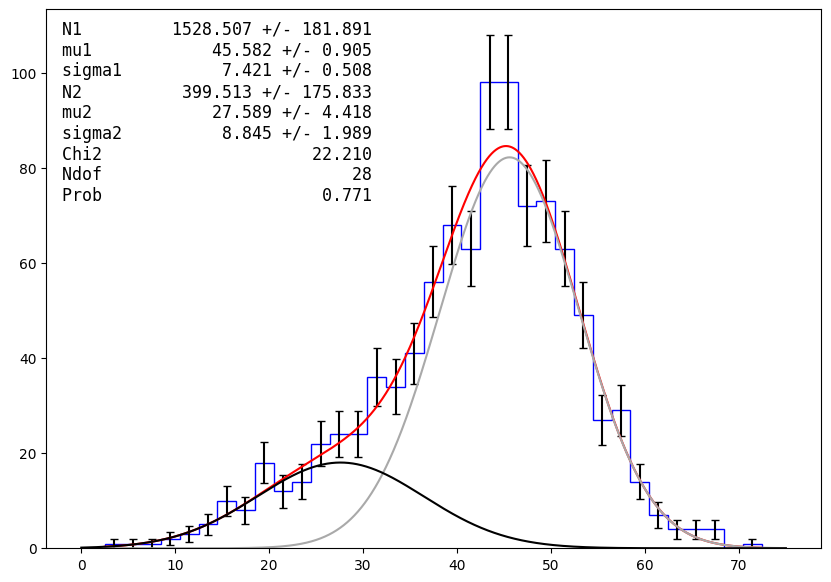

In [32]:
def dgauss_pdf(x, N1, mu1, sigma1, N2, mu2, sigma2):
    return N1 * stats.norm.pdf(x, mu1, sigma1) + N2 * stats.norm.pdf(x, mu2, sigma2)
def gauss_pdf(x, N1, mu1, sigma1):
    return N1 * stats.norm.pdf(x, mu1, sigma1)


test = Datahandler(size, 35)
values, errors = test.chi2fit(dgauss_pdf, N1 = 1000, mu1 = 40, sigma1 = 5, N2 = 50, mu2 = 20, sigma2 = 5, fulldata = False)
test.initplot()
test.quickplot()
test.plotfit()
x_line = np.linspace(0, 75, 10000)
plt.plot(x_line, gauss_pdf(x_line, *values[:3]), color = "darkgrey")
plt.plot(x_line, gauss_pdf(x_line, *values[3:]), color = "k")

plt.show()